In [1]:
from scipy import io as sio
from matplotlib import pyplot as plt
import numpy as np
import random

## Блокнот, чтобы собрать все нужные данные для LSTM

### Повторение характеристик, использующихся в патенте


Previously, we discovered that the following characteristics of wave trains are beneficial for identifying various neurodegenerative diseases:
* Frequency
* Duration Periods
* Bandwith
What is important is that these characteristics do not depend on the equipment used to record the EMG, making them theoretically applicable to any hardware setup. Our experiments have demonstrated the effectiveness of the wave-train method (citation here). However, the simplified version of the method has shown a slight decrease in performance on the current dataset. 

Other research studies (cite Thai paper) have shown that temporal characteristics of tremor can aid in distinguishing Parkinson's disease (PD) from essential tremor (ET), with excellent results reported. We tested their method on our data and found that the proposed method can indeed assist in classifying PD from ET, and even PD from the Control group. However, the accuracy we obtained is significantly lower than that reported in the (cite Thai paper).

In this reasearch we pursue our quete to find a method for early stage diagnostics of neurogenerative diseases, and we want to combine wave-trains from (cite paper) with their temporal aspects. For the latter  we experiment with various sequence models, which can learn to  capture temporal dependences. 

In order to compare the role of temporal information, we start from the same features used in earlier experiments.

Из патента следуюет, что используются 3 признака:
* Центральная частота -Freq
* Длительность на полувысоте - DuratPeriods 
* Ширина полосы частот на полувысоте - BandwidthesHz

Также важен четвертый параметр, время, чтобы расположить всплески по очередности:
* Time - время между последовательноми всплесками


Начнем с одной группой пациентов, соберем все соотвествующие фамилии,совпадающие с названиями файлов.

In [43]:
from os import listdir
from os.path import isfile, join
data_path = 'C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl/'
patients = set()
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
# filter the files by name
for f in onlyfiles:
    if f[-3:]=='txt':
        pat = f.split('_')[0]
        patients.add(pat)
print(f'Пациенты из группы {data_path.split("/")[-2]}: {patients}')

Пациенты из группы Margo_DATA_Control_rassl: {'Сидо0205.txt', 'Черк0208.txt', 'Лега0204.txt', 'Аста0201.txt', 'Фрол0206.txt', 'Дюки0202.txt', 'Хвал0207.txt', 'Керш0203.txt'}


In [44]:
# вспомогательная функция чтобы загрузить все параметры, которые нас интерусуют, из формата матлаб
def load_parameter(patient, EMG, parameter, data_path = 'C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl/'):
    print(data_path +'/'+patient + '_EMG' + str(EMG)+ parameter + '.mat')
    mat_contents = sio.loadmat(data_path +'/'+patient + '_EMG' + str(EMG)+ parameter + '.mat')
    if parameter =='BandwidthesHz':
        signal  = mat_contents['Flash_Band_In_Hz_Stack']
    elif parameter == 'DuratPeriods':
        signal = mat_contents['Flash_Durat_In_Periods_Stack']
    elif parameter == 'Freq':
        signal  = mat_contents['Flash_Freq_Stack']
    elif parameter == 'Time':
         signal = mat_contents['Flash_Time_Stack']
    else:
        print('no parameter, but the keys are', sorted(mat_contents.keys()))
    return signal

Мы берем лишь одну руку у пациентов на данном этапе,  у правых - правую, у левых - левую, а у ЭТ - можно любую, у контроля - тоже любую.

The number of detected wave trains varies between different data sequences and even among different limbs of a patient. It is common in research studies to place sensors on the patient's hand. Thus, for the initial set of experiments, we have chosen to focus on the hand as the sensor placement location.

For patients with Parkinson's disease (PD) exhibiting tremor in the right hand, we analyze the data from the right hand. Similarly, for PD patients with tremor in the left hand, we analyze the data from the left hand. For control subjects and essential tremor (ET) patients, data from either hand can be used, but we have selected the right hand for consistency.


In [45]:
# вспомогательная функция, чтобы загрузить все выбранные сигналы, а также время каждого сигнала
def extract_wavetrains(patients, data_path, emg):
    for n, patient in enumerate(patients):
        # у нас 4 сигнала EMG, но мы берем лишь 1, правую или левую руку
        # TODO: проверить посл, правая первая, оевая вторая.

        freq_signal = load_parameter(patient,emg,'Freq',data_path)
        Flash_Durat_signal = load_parameter(patient,emg,'DuratPeriods',data_path)
        BandwidthesHz_signal = load_parameter(patient,emg,'BandwidthesHz',data_path)
        TimeSignal = load_parameter(patient,emg,'Time',data_path)
            
        # достать время для этих сигналов -- пока не изпользуется, возможно для нормализации
        mat_contents = sio.loadmat(data_path + patient + '_EMG1TimeAndFrequency.mat')
        time_signal  = mat_contents['Time']
        total_sec = max(time_signal.ravel())-min(time_signal.ravel())
        
        # sort all signals by time (in the order of recording)
        time_order = sorted(range(len(TimeSignal)), key=lambda k: TimeSignal[k])
        features = (freq_signal,Flash_Durat_signal,BandwidthesHz_signal,TimeSignal,time_order, total_sec)
    return features

Теперь осталось только сортировать наши всплески по пере их появления, и добавить переменную времени. Следующая функция про это.

In [46]:
def sort_by_time(features):
    '''time is always last in the order of features'''
    freq_signal,Flash_Durat_signal,BandwidthesHz_signal,TimeSignal,time_order, total_sec = features
    freq_signal_ordered = [freq_signal[i][0] for i in time_order]
    Flash_Durat_signal_ordered = [Flash_Durat_signal[i][0] for i in time_order]
    BandwidthesHz_signal_ordered = [BandwidthesHz_signal[i][0] for i in time_order]
    timeSignal_ordered =  [TimeSignal[i][0] for i in time_order]
    # get time  features for LSTM model in the shape of time between two wavetrains
    t1 = [0]+timeSignal_ordered
    t2 = timeSignal_ordered + [0]
    timeSignal_for_lstm = [a_i - b_i for a_i, b_i in zip(t2, t1)]
    return freq_signal_ordered,Flash_Durat_signal_ordered,BandwidthesHz_signal_ordered, timeSignal_ordered, timeSignal_for_lstm

Теперь попробуем извлечь и построить характеристики для одного из пациентов, выбранного случайным образом из контрольной группы.

In [47]:
patient = random.sample(patients, 1)
patient

['Сидо0205.txt']

In [7]:
features = extract_wavetrains(patient, data_path, 1)

C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Хвал0207.txt_EMG1Freq.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Хвал0207.txt_EMG1DuratPeriods.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Хвал0207.txt_EMG1BandwidthesHz.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Хвал0207.txt_EMG1Time.mat


In [8]:
freq, flash_d, bandw, time_s, time_lstm = sort_by_time(features)

В настоящий момент, планируется использовать время от последнего всплеска как одну из характеристик для входа в LSTM.

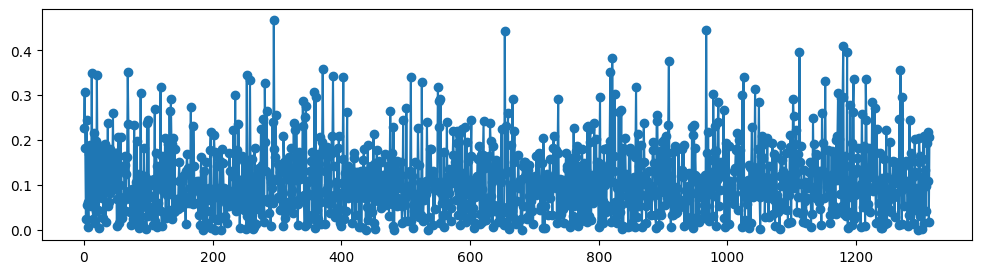

In [9]:
plt.figure(figsize=(12,3))
plt.plot(time_lstm[:-1], '-o')

timeSignal_ordered
#print(timeSignal_ordered.insert(0,0))

Text(0, 0.5, 'Frequency')

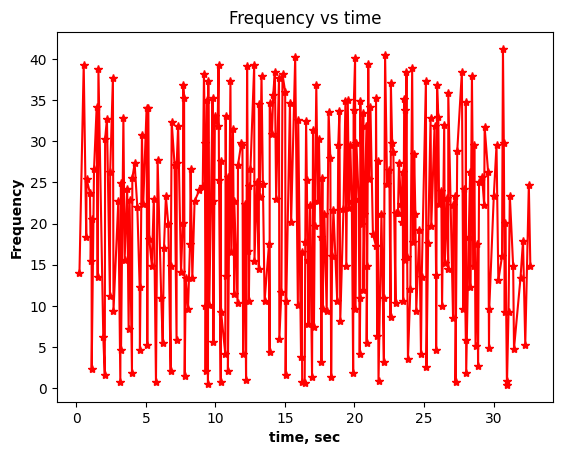

In [10]:
plt.plot(time_s[:300], freq[:300], 'r-*')
plt.title("Frequency vs time")
plt.xlabel('time, sec', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')

Text(0, 0.5, 'Flash duration')

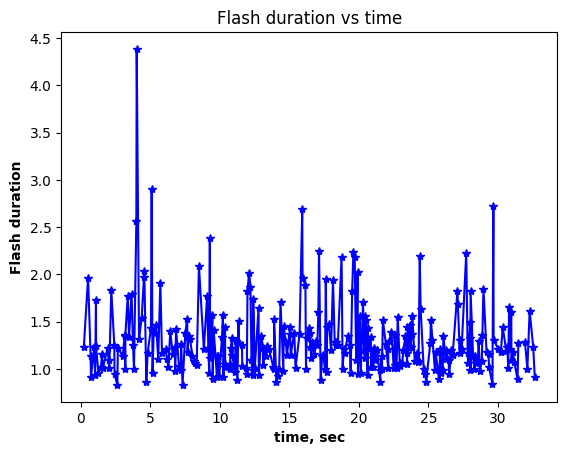

In [11]:
plt.plot(time_s[:300], flash_d[:300], 'b-*')
plt.title("Flash duration vs time")
plt.xlabel('time, sec', fontweight='bold')
plt.ylabel('Flash duration', fontweight='bold')

Text(0, 0.5, 'Bandwidth')

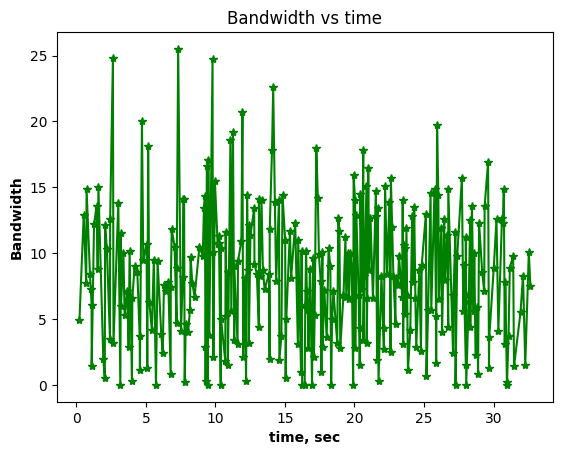

In [12]:
plt.plot(time_s[:300], bandw[:300], 'g-*')
plt.title("Bandwidth vs time")
plt.xlabel('time, sec', fontweight='bold')
plt.ylabel('Bandwidth', fontweight='bold')

Text(0, 0.5, 'Bandwidth, Flash Dur, Freq')

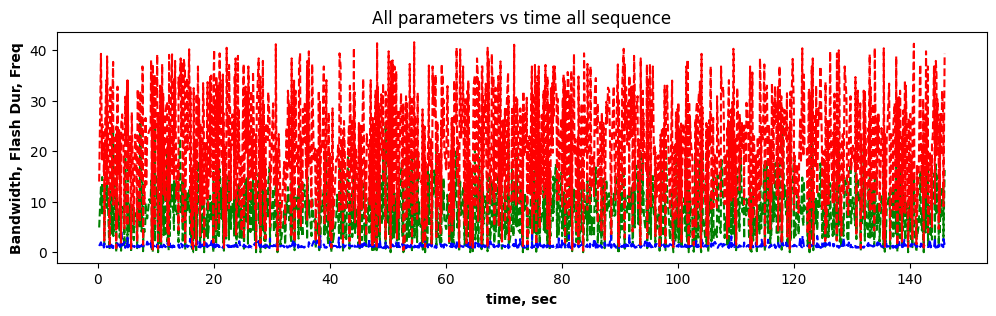

In [13]:
plt.figure(figsize=(12,3))
plt.plot(time_s, bandw, 'g--')
plt.plot(time_s, flash_d, 'b--')
plt.plot(time_s, freq, 'r--')
plt.title("All parameters vs time all sequence")
plt.xlabel('time, sec', fontweight='bold')
plt.ylabel('Bandwidth, Flash Dur, Freq', fontweight='bold')

Проверка времени между всплесками с помощью построенной диаграммы.

Text(0.5, 1.0, 'Histogram of the time between wavetrains')

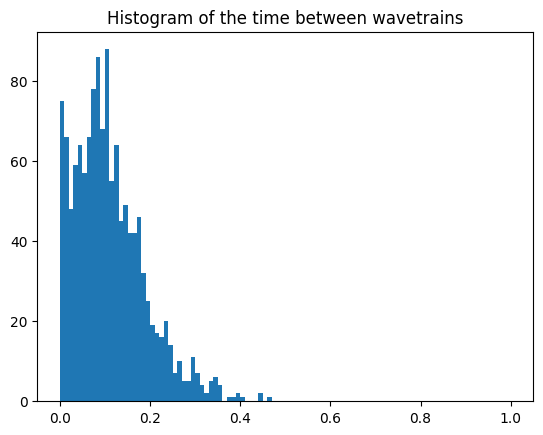

In [14]:
plt.hist(time_lstm,bins=100, range=(0,1))
plt.title("Histogram of the time between wavetrains")

In [15]:
len(time_s)

1315

## Выводы
Все данные разной длины (разное кол-во всплесков),  и разной размерности,  и в разном диапазоне значений. так что их необходимо будет нормализовывать. 
В то же время, данные более-менее равномерны в течении всей последовательности записи у контрольной группы.
На данном этапе, мы предлагаем брать отрезки по 80 всплесков, с небольшими повторениями (порядка 10 всплесков), и на этих отрезка пробовать классифицировать данные. 
В дальнейшем, можно попробоать различные сценарии, например, с предсказаниями следующего всплекска.
Не совсем понятно, что лучше делать со временем, пока самое просто будет закодировать время всплеска в диапазоне 0-1. 


As the plots demonstrate, the different characteristics of wave trains fall within different ranges of values, necessitating their normalization prior to inputting them into the LSTM model. Furthermore, the length of a sequence of wave trains varies among patients, a challenge we will address in a later stage by employing a sliding window approach.

The timing of wave train occurrences serves as an important parameter, enabling the capture of various relational information within our data. However, drawing an analogy with text models (cite), preprocessing of time is required before utilizing it as a feature in the input of a deep learning model. Other researchers have employed various methods for encoding time (provide a list of methods). In our initial baseline, we plan to utilize the time between consecutive wave trains, measured in seconds.

Далее мы подготавливаем данные для LSTM, сохраняя их, но пока не разделяя их на отдельные тест сеты. Все эти эксперименты могут быть сделаны дальше, во время работы с SVM.

EMG1 - левая рука
EMG2 - правая рука
EMG3 - левая нога
EMG4 - правая нога

#### Данные для контроля

In [60]:
import csv
strFileName = 'C:/Users/khokhlovam/Documents/kotelnikov/data/data_lstm_test_checked.csv'

Про данные:
data_lstm_test1.csv - исходная длина файлов. 

In [61]:
data_path = 'C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl/'
patients = set()
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
# filter the files by name
for f in onlyfiles:
    if f[-3:]=='txt':
        pat = f.split('_')[0]
        patients.add(pat)
print(f'Пациенты из группы {data_path.split("/")[-2]}: {patients}')

Пациенты из группы Margo_DATA_Control_rassl: {'Сидо0205.txt', 'Черк0208.txt', 'Лега0204.txt', 'Аста0201.txt', 'Фрол0206.txt', 'Дюки0202.txt', 'Хвал0207.txt', 'Керш0203.txt'}


К сожалению, с именами пациентов проблемы, поэтому приходится их кодировать.

In [62]:
pat2id = {'Черк0208.txt':0, 'Керш0203.txt':1, 'Аста0201.txt':2, 'Лега0204.txt':3, 'Хвал0207.txt':4, 'Дюки0202.txt':5, 'Сидо0205.txt':6, 'Фрол0206.txt':7,
         'Шелу0209.txt':8, 'Сави0208.txt':9, 'Наза0205.txt':10, 'Колг0203.txt':11, 'Савв0207.txt':12, 'Медв0204.txt':13, 'Кова0202.txt':14, 'Ерми0201.txt':15, 'Погр0206.txt':16,
          'Голу0203.txt':17, 'Ротм0208.txt':18, 'Хлюс02011.txt':19, 'Грек0204.txt':20, 'Губа0205.txt':21, 'Серо0209.txt':22, 'Гава0202.txt':23, 'Бело0201.txt':24, 'Пана0207.txt':25, 'Соло02010.txt':26, 'Павл0206.txt':27,
         'Молю02010.txt':28, 'Тихо02013.txt':29, 'Муха02011.txt':30, 'Кудр0203.txt':31, 'Соко02012.txt':32, 'Ершо0202.txt':33, 'Купр0204 .txt':34, 'Куту0205.txt':35, 'Луче0207.txt':36, 'Даке0201.txt':37, 'Лити0206.txt':38, 'Макс0208.txt':39, 'Миро0209.txt':40}

In [63]:
pat2id

{'Черк0208.txt': 0,
 'Керш0203.txt': 1,
 'Аста0201.txt': 2,
 'Лега0204.txt': 3,
 'Хвал0207.txt': 4,
 'Дюки0202.txt': 5,
 'Сидо0205.txt': 6,
 'Фрол0206.txt': 7,
 'Шелу0209.txt': 8,
 'Сави0208.txt': 9,
 'Наза0205.txt': 10,
 'Колг0203.txt': 11,
 'Савв0207.txt': 12,
 'Медв0204.txt': 13,
 'Кова0202.txt': 14,
 'Ерми0201.txt': 15,
 'Погр0206.txt': 16,
 'Голу0203.txt': 17,
 'Ротм0208.txt': 18,
 'Хлюс02011.txt': 19,
 'Грек0204.txt': 20,
 'Губа0205.txt': 21,
 'Серо0209.txt': 22,
 'Гава0202.txt': 23,
 'Бело0201.txt': 24,
 'Пана0207.txt': 25,
 'Соло02010.txt': 26,
 'Павл0206.txt': 27,
 'Молю02010.txt': 28,
 'Тихо02013.txt': 29,
 'Муха02011.txt': 30,
 'Кудр0203.txt': 31,
 'Соко02012.txt': 32,
 'Ершо0202.txt': 33,
 'Купр0204 .txt': 34,
 'Куту0205.txt': 35,
 'Луче0207.txt': 36,
 'Даке0201.txt': 37,
 'Лити0206.txt': 38,
 'Макс0208.txt': 39,
 'Миро0209.txt': 40}

In [64]:
with open(strFileName, "a",encoding='utf8',newline='') as f:
    writer = csv.writer(f, delimiter=',',  quoting=csv.QUOTE_NONE)
    for patient in patients:
        features = extract_wavetrains([patient], data_path, 2)
        freq, flash_d, bandw, _, time_lstm = sort_by_time(features)     
        writer.writerow(['control']+ [pat2id[patient]] +  freq)
        writer.writerow(['control']+ [pat2id[patient]] +  flash_d)
        writer.writerow(['control']+ [pat2id[patient]] +  bandw)
        writer.writerow(['control']+ [pat2id[patient]] +  time_lstm)

C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Сидо0205.txt_EMG2Freq.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Сидо0205.txt_EMG2DuratPeriods.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Сидо0205.txt_EMG2BandwidthesHz.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Сидо0205.txt_EMG2Time.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Черк0208.txt_EMG2Freq.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Черк0208.txt_EMG2DuratPeriods.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Control_rassl//Черк0208.txt_EMG2BandwidthesHz.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA

#### Данные для БП левый 

In [65]:
data_path = 'C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Left_rassl/'
patients = set()
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
# filter the files by name
for f in onlyfiles:
    if f[-3:]=='txt':
        pat = f.split('_')[0]
        patients.add(pat)
print(f'Пациенты из группы {data_path.split("/")[-2]} {len(patients)}: {patients}')

Пациенты из группы Margo_DATA_Left_rassl 9: {'Кова0202.txt', 'Савв0207.txt', 'Сави0208.txt', 'Медв0204.txt', 'Колг0203.txt', 'Наза0205.txt', 'Шелу0209.txt', 'Ерми0201.txt', 'Погр0206.txt'}


In [66]:
with open(strFileName, "a",encoding='utf8',newline='') as f:
    writer = csv.writer(f, delimiter=',',  quoting=csv.QUOTE_NONE)
    for patient in patients:
        features = extract_wavetrains([patient], data_path, 1)
        freq, flash_d, bandw, _, time_lstm = sort_by_time(features)     
        writer.writerow(['PDL']+ [pat2id[patient]] +  freq)
        writer.writerow(['PDL']+ [pat2id[patient]] +  flash_d)
        writer.writerow(['PDL']+ [pat2id[patient]] +  bandw)
        writer.writerow(['PDL']+ [pat2id[patient]] +  time_lstm)

C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Left_rassl//Кова0202.txt_EMG1Freq.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Left_rassl//Кова0202.txt_EMG1DuratPeriods.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Left_rassl//Кова0202.txt_EMG1BandwidthesHz.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Left_rassl//Кова0202.txt_EMG1Time.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Left_rassl//Савв0207.txt_EMG1Freq.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Left_rassl//Савв0207.txt_EMG1DuratPeriods.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Left_rassl//Савв0207.txt_EMG1BandwidthesHz.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Left_rassl//Савв0207

#### Данные для БП правый

In [67]:
data_path = 'C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Right_rassl/'
patients = set()
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
# filter the files by name
for f in onlyfiles:
    if f[-3:]=='txt':
        pat = f.split('_')[0]
        patients.add(pat)
print(f'Пациенты из группы {data_path.split("/")[-2]}: {patients}')

Пациенты из группы Margo_DATA_Right_rassl: {'Соло02010.txt', 'Павл0206.txt', 'Гава0202.txt', 'Ротм0208.txt', 'Грек0204.txt', 'Серо0209.txt', 'Губа0205.txt', 'Пана0207.txt', 'Голу0203.txt', 'Хлюс02011.txt', 'Бело0201.txt'}


In [68]:
with open(strFileName, "a",encoding='utf8',newline='') as f:
    writer = csv.writer(f, delimiter=',',  quoting=csv.QUOTE_NONE)
    for patient in patients:
        features = extract_wavetrains([patient], data_path, 2)
        freq, flash_d, bandw, _, time_lstm = sort_by_time(features)     
        writer.writerow(['PDR']+ [pat2id[patient]] +  freq)
        writer.writerow(['PDR']+ [pat2id[patient]] +  flash_d)
        writer.writerow(['PDR']+ [pat2id[patient]] +  bandw)
        writer.writerow(['PDR']+ [pat2id[patient]] +  time_lstm)
        print(pat2id[patient])

C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Right_rassl//Соло02010.txt_EMG2Freq.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Right_rassl//Соло02010.txt_EMG2DuratPeriods.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Right_rassl//Соло02010.txt_EMG2BandwidthesHz.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Right_rassl//Соло02010.txt_EMG2Time.mat
26
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Right_rassl//Павл0206.txt_EMG2Freq.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Right_rassl//Павл0206.txt_EMG2DuratPeriods.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Right_rassl//Павл0206.txt_EMG2BandwidthesHz.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_Right_

#### Данные для ЭТ

In [69]:
data_path = 'C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_ET_rassl/'
patients = set()
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
# filter the files by name
for f in onlyfiles:
    if f[-3:]=='txt':
        pat = f.split('_')[0]
        patients.add(pat)
print(f'Пациенты из группы {data_path.split("/")[-2]}: {patients}')

Пациенты из группы Margo_DATA_ET_rassl: {'Ершо0202.txt', 'Куту0205.txt', 'Луче0207.txt', 'Тихо02013.txt', 'Купр0204 .txt', 'Лити0206.txt', 'Даке0201.txt', 'Молю02010.txt', 'Соко02012.txt', 'Макс0208.txt', 'Миро0209.txt', 'Кудр0203.txt', 'Муха02011.txt'}


In [70]:
with open(strFileName, "a",encoding='utf8',newline='') as f:
    writer = csv.writer(f, delimiter=',',  quoting=csv.QUOTE_NONE)
    for patient in patients:
        features = extract_wavetrains([patient], data_path, 2)
        freq, flash_d, bandw, _, time_lstm = sort_by_time(features)     
        writer.writerow(['ET']+ [pat2id[patient]] +  freq)
        writer.writerow(['ET']+ [pat2id[patient]] +  flash_d)
        writer.writerow(['ET']+ [pat2id[patient]] +  bandw)
        writer.writerow(['ET']+ [pat2id[patient]] +  time_lstm)
        print(pat2id[patient])

C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_ET_rassl//Ершо0202.txt_EMG2Freq.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_ET_rassl//Ершо0202.txt_EMG2DuratPeriods.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_ET_rassl//Ершо0202.txt_EMG2BandwidthesHz.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_ET_rassl//Ершо0202.txt_EMG2Time.mat
33
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_ET_rassl//Куту0205.txt_EMG2Freq.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_ET_rassl//Куту0205.txt_EMG2DuratPeriods.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_ET_rassl//Куту0205.txt_EMG2BandwidthesHz.mat
C:/Users/khokhlovam/Documents/kotelnikov/data/Параметры всплесков - рассл/Margo_DATA_ET_rassl//Куту0205.txt_EMG2Time

In [ ]:
At this stage we have the data to test our first baseline LSTM model. 

# Часть 2



Поскольку мы знаем лишь, какие признаки помогут отличать различные нейрогенеративные заболевания на основе наших экспериментов, в следующей группу мы пробуем использовать все параметры всплесков.
А именно:
* Частоты
* амплитуды
* секунды 
* периоды
* бандвиз 
* фазы
* время

# Проверка для Алексея

Оконное преобразование может понадобиться для того, чтобы визуально разделить наборы данных, а потом придумать предварительное преобразование данных, поступающих в нейросеть. Мы бы воспоспользовались оконным преобразованием, если бы увидели на присланной вами диаграмме неравномерности плотности точек во времени. Но судя по тому, что таких неравномерностей невидно, хвататься надо за другое.

Насколько я помню, у меня закономерности в периодах наблюдались не для всех всплесков, а только для всплесков в ограниченных диапазонах частот, например, от 3 до 21 Гц. Я наблюдал это на правых руках у правотреморных пациентов с БП в расслабленном состоянии. При этом наблюдалась ярко выраженная отрицательная корреляция между длительностью следующих друг за другом всплесков. То есть, после длительного всплеска шел короткий всплеск, а после короткого всплеска шел длинный всплеск. У ЭТ ничего похожего не наблюдалось.

Пожалуйста, попробуйте это как-то визуализировать. Я это визуализировал очень просто. Взял всплески через один, построил 2 вектора: четные всплески, нечетные всплеск. И сунул в скаттер-плот. Получилась ярко выраженная обратная зависимость.По идеи рекурсивная нейросеть тоже должна это отловить. Кстати, можете построить модель сигнала и это проверить, чтобы убедиться, что она это может.


In [2]:
import pandas as pd

In [3]:
data_path = 'C:/Users/khokhlovam/Documents/kotelnikov/data_lstm_test1.csv'
df =pd.read_csv(data_path, header=None, names=range(1564)) # 

Feature order is:  freq, flash_d, bandw, time_lstm (time since last wavetrain)

In [20]:
df.head(75)


,0,1,2,3,4,5,6,7,8,9,...,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563
0,control,0,23.7000,13.1000,38.4000,9.2000,25.4000,30.4000,38.1000,13.4000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,control,0,1.0902,1.1266,1.1520,2.4472,0.9652,1.1552,1.2954,1.0184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,control,0,8.8000,4.0000,12.8000,3.1000,13.2000,11.3000,14.1000,6.2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,control,0,0.1480,0.0820,0.0960,0.0820,0.0640,0.0820,0.1280,0.1700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,control,1,39.2000,40.5000,14.8000,36.8000,24.6000,5.6000,29.5000,28.1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,PDR,39,15.7000,2.1000,7.7000,5.8000,9.7000,13.5000,5.6000,10.1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,PDR,39,0.2720,0.2000,0.0000,0.1860,0.0300,0.1520,0.0140,0.0880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,PDR,29,22.2000,10.6000,29.8000,38.4000,14.9000,5.2000,28.2000,9.6000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,PDR,29,1.3764,2.8196,0.9536,0.9984,0.9536,1.4144,1.1280,1.1904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's try to plot the wavetrains odd and even for each class of patients :

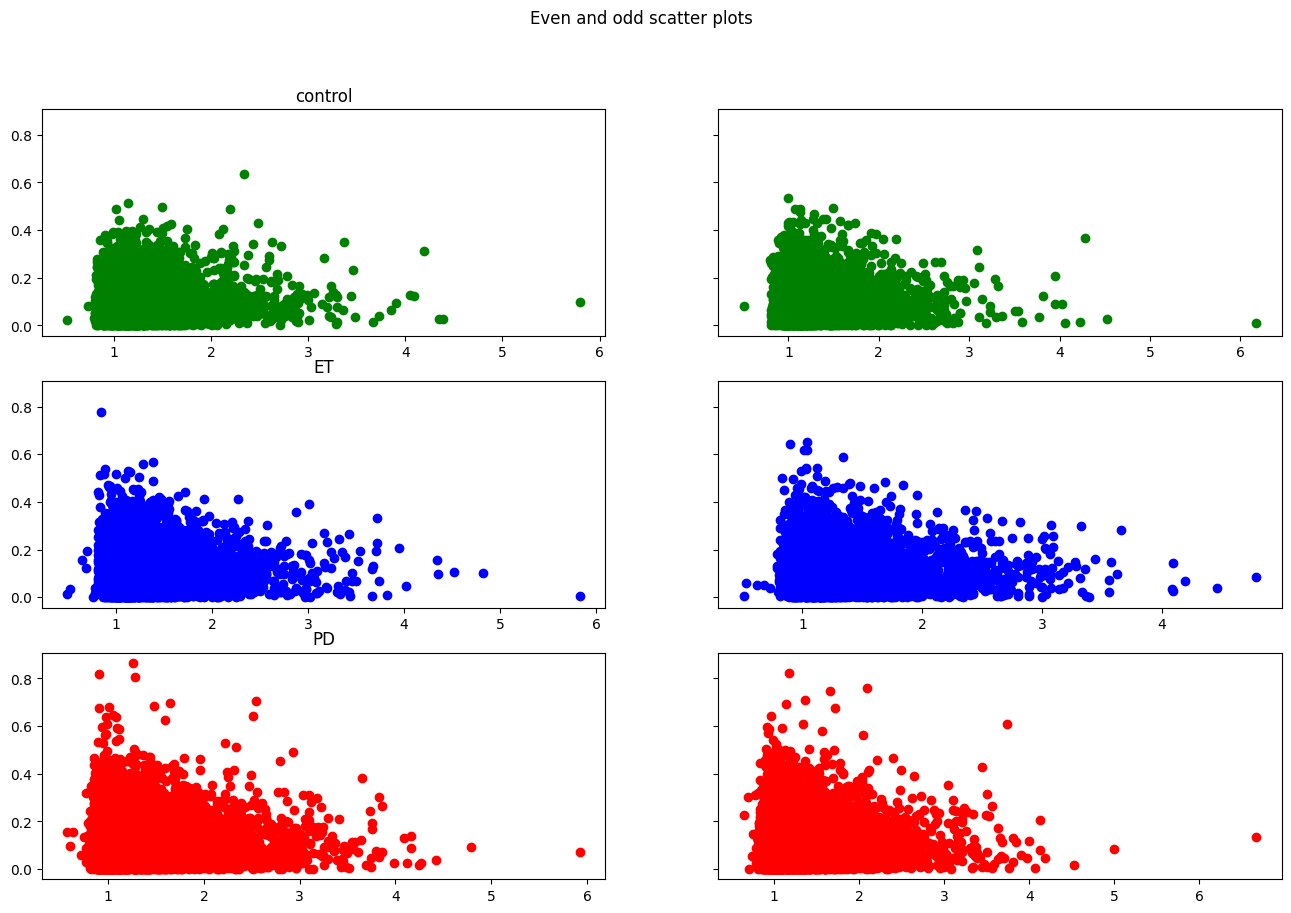

In [87]:
fig, axs = plt.subplots(3,2, figsize=(16,10), sharey=True)
for i in range(1,len(df),4): # take only flash_fr
    # print(i, i+2, df.iloc[[i]][0].values[0])
    if df.iloc[[i]][0].values[0] == 'control':
        flash_d = df.iloc[[i]].values.tolist()[0]
        flash_d = [x for x in  flash_d if str(x) != 'nan']
        time_v = df.iloc[[i+2]].values.tolist()[0]
        time_v = [x for x in  time_v if str(x) != 'nan']
        axs[0,0].scatter(flash_d[2::2],time_v[2::2], color='g')
        axs[0,1].scatter(flash_d[3::2],time_v[3::2], color='g')
        axs[0,0].set_title('control')
    elif df.iloc[[i]][0].values[0] == 'ET':
        flash_d = df.iloc[[i]].values.tolist()[0]
        flash_d = [x for x in  flash_d if str(x) != 'nan']
        time_v = df.iloc[[i+2]].values.tolist()[0]
        time_v = [x for x in  time_v if str(x) != 'nan']
        if len(flash_d)<len(time_v):
            time_v = time_v[:(len(flash_d))]
#             print(len(flash_d), len(time_v))
        axs[1,0].scatter(flash_d[2::2],time_v[2::2],color='b')
        axs[1,1].scatter(flash_d[3::2],time_v[3::2],color='b')
        axs[1,0].set_title('ET')
    else:
        flash_d = df.iloc[[i]].values.tolist()[0]
        flash_d = [x for x in  flash_d if str(x) != 'nan']
        time_v = df.iloc[[i+2]].values.tolist()[0]
        time_v = [x for x in  time_v if str(x) != 'nan']
        if len(flash_d)<len(time_v):
            time_v = time_v[:(len(flash_d))]
#             print(len(flash_d), len(time_v))
        axs[2,0].scatter(flash_d[2::2],time_v[2::2], color='r')
        axs[2,1].scatter(flash_d[3::2],time_v[3::2], color='r')
        axs[2,0].set_title('PD')
    fig.suptitle('Even and odd scatter plots')

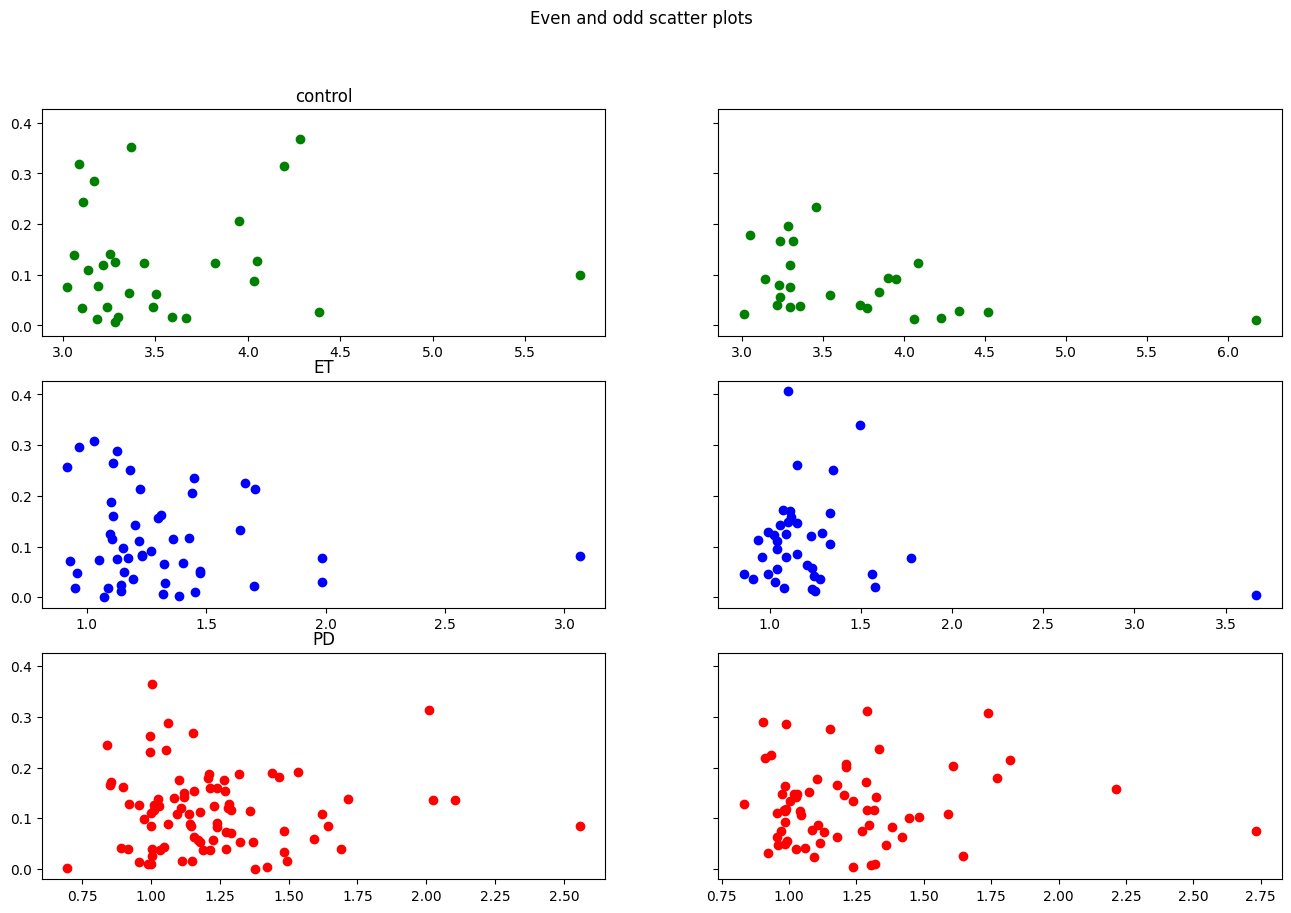

In [105]:
freq_range = [3,21]
fig, axs = plt.subplots(3,2, figsize=(16,10), sharey=True)
for i in range(1,len(df),4): # take only flash_fr
#     print(i, i+2, df.iloc[[i]][0].values[0])
    if df.iloc[[i]][0].values[0] == 'control':
        flash_d = df.iloc[[i]].values.tolist()[0]
        valid_indexes = [i for i in range(2,len(flash_d)) if str(flash_d[i]) !='nan' and  flash_d[i]>freq_range[0] and flash_d[i]<freq_range[1]]
        flash_d = [flash_d[x] for x in valid_indexes]
        time_v = df.iloc[[i+2]].values.tolist()[0]
        time_v = [time_v[x] for x in valid_indexes]
        axs[0,0].scatter(flash_d[0::2],time_v[0::2], color='g')
        axs[0,1].scatter(flash_d[1::2],time_v[1::2], color='g')
        axs[0,0].set_title('control')
    elif df.iloc[[i]][0].values[0] == 'ET':
        flash_d = df.iloc[[i]].values.tolist()[0]
        flash_d = [flash_d[x] for x in valid_indexes]
        time_v = df.iloc[[i+2]].values.tolist()[0]
        time_v = [time_v[x] for x in valid_indexes]
        axs[1,0].scatter(flash_d[0::2],time_v[0::2], color='b')
        axs[1,1].scatter(flash_d[1::2],time_v[1::2], color='b')
        axs[1,0].set_title('ET')
    else:
        flash_d = df.iloc[[i]].values.tolist()[0]
        flash_d = [flash_d[x] for x in valid_indexes]
        time_v = df.iloc[[i+2]].values.tolist()[0]
        time_v = [time_v[x] for x in valid_indexes]
        axs[2,0].scatter(flash_d[0::2],time_v[0::2], color='r')
        axs[2,1].scatter(flash_d[1::2],time_v[1::2], color='r')
        axs[2,0].set_title('PD')
    fig.suptitle('Even and odd scatter plots')

Насколько я помню, у меня закономерности в периодах наблюдались не для всех всплесков, а только для всплесков в ограниченных диапазонах частот, например, от 3 до 21 Гц. Я наблюдал это на правых руках у правотреморных пациентов с БП в расслабленном состоянии. При этом наблюдалась ярко выраженная отрицательная корреляция между длительностью следующих друг за другом всплесков. То есть, после длительного всплеска шел короткий всплеск, а после короткого всплеска шел длинный всплеск. У ЭТ ничего похожего не наблюдалось.

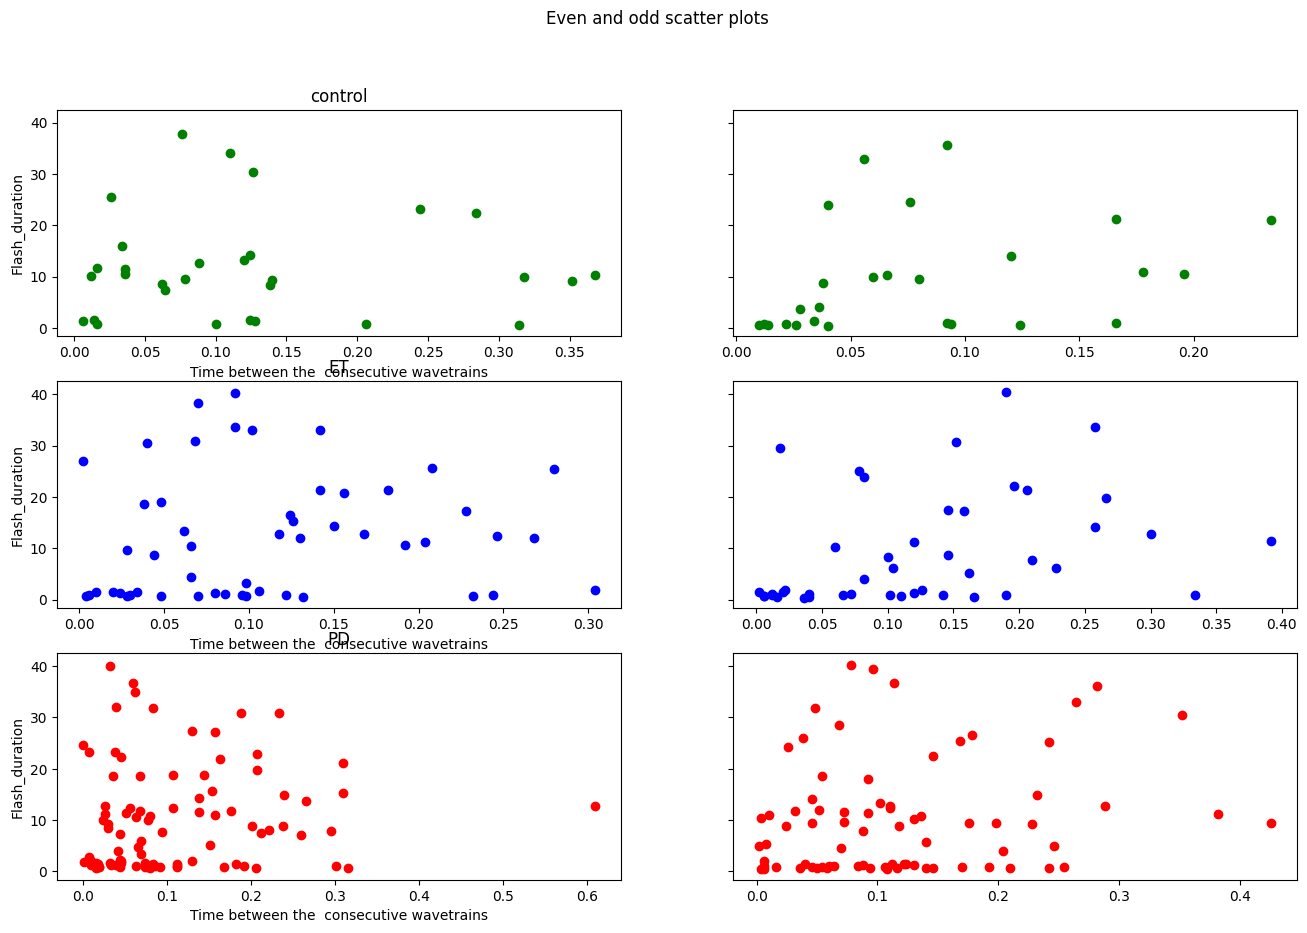

In [121]:
freq_valid = [3,21] # 0 
fig, axs = plt.subplots(3,2, figsize=(16,10), sharey=True)
for i in range(0,len(df),4): # take only flash_fr
    label = df.iloc[[i]][0].values[0]
    flash_d = df.iloc[[i]].values.tolist()[0]
    freq_range = df.iloc[[i+1]].values.tolist()[0]
    time_v = df.iloc[[i+3]].values.tolist()[0]
    valid_indexes = [i for i in range(2,len(freq_range)) if str(freq_range[i]) !='nan' and  freq_range[i]>freq_valid[0] and freq_range[i]<freq_valid[1]]
    flash_d = [flash_d[x] for x in valid_indexes]
    time_v = [time_v[x] for x in valid_indexes]
    if label == 'control':
        c = 'g'
        j = 0
        text = 'control'        
    elif label == 'ET':
        c = 'b'
        j = 1
        text = 'ET' 
    else:
        c = 'r'
        j = 2
        text = 'PD' 
    axs[j,0].scatter(time_v[0::2], flash_d[0::2], color=c)
    axs[j,1].scatter(time_v[1::2],flash_d[1::2], color=c)
    axs[j,0].set_xlabel('Time between the  consecutive wavetrains')
    axs[j,0].set_ylabel('Flash_duration')
    axs[j,0].set_title(text)
    fig.suptitle('Even and odd scatter plots')

Маргарита, подождите фильтровать частоты. Давайте сначала убедимся, что мы строим одни и те же картинки. На моих картинках на оси х отложено duration всплеска, а у - duration  следующего всплеска.
 То есть я разделил все всплески на чётные и  нечетные и тупо использовал нечетные в качестве х, а чётные в качестве у или наоборот. Поэтому диапазон значений по осям х и у примерно одинаковый. А у вас он разный. Чего быть никак не может :-)
Вот у меня на картинке слева БП, а справа ЭТ.


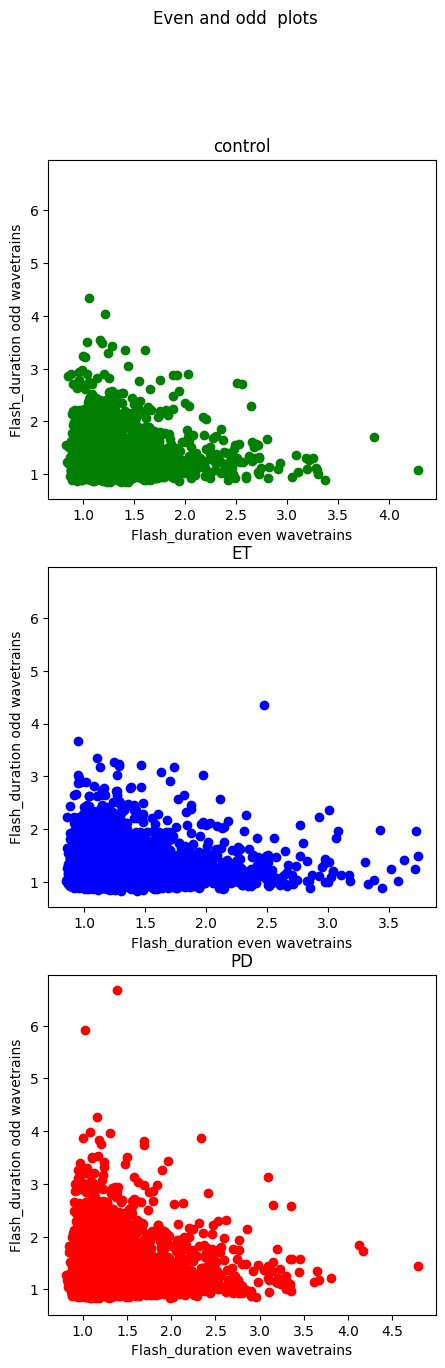

In [12]:
freq_valid = [3,21] # 0 
fig, axs = plt.subplots(3,1, figsize=(5,15), sharey=True)
for i in range(0,len(df),4): # take only flash_fr
    label = df.iloc[[i]][0].values[0]
    flash_d = df.iloc[[i+1]].values.tolist()[0]
    freq_range = df.iloc[[i]].values.tolist()[0]
    time_v = df.iloc[[i+3]].values.tolist()[0]
    valid_indexes = [i for i in range(2,len(freq_range)) if str(freq_range[i]) !='nan' and  freq_range[i]>freq_valid[0] and freq_range[i]<freq_valid[1]]
    flash_d = [flash_d[x] for x in valid_indexes]
    time_v = [time_v[x] for x in valid_indexes]
    if label == 'control':
        c = 'g'
        j = 0
        text = 'control'        
    elif label == 'ET':
        c = 'b'
        j = 1
        text = 'ET' 
    else:
        c = 'r'
        j = 2
        text = 'PD' 
    even=flash_d[0::2]
    odd =flash_d[1::2]
    # only if the number of wavetrains is odd
    min_len = min(len(even),len(odd))
    even=even[:min_len]
    odd=odd[:min_len]
    axs[j].scatter(even, odd, color=c)
    axs[j].set_xlabel('Flash_duration even wavetrains')
    axs[j].set_ylabel('Flash_duration odd wavetrains')
    axs[j].set_title(text)
    fig.suptitle('Even and odd  plots')

здесь следует оменить, что я не разделяю БП левых и правых, они все тут. 


Словами скажу только, что при сравнении правой треморной руки у БП и правой руки у контроля на частотной диаграмме примерно на частоте 6 Гц наступает коренной перелом, и большое синее облако превращается в большое красное облако. Похоже, что эффект ещё более сильный, чем те, что мы описали в статье в Sensors. Из этого можно сделать следующий вывод. Зная центральную частоту и длительность всплесков,  по этим двум параметрам можно сконструировать простейшие правило, которое будет отличать бп от контроля. Очень странно, что нейросети с этим не справляются. Вся надежда на вас. Только вы можете догадаться, что мы не так суем в нейросети, что они не способны найти решения, лежащие на поверхности :-)

Построю теперь только БП правый и контроль, возьмем частоты от 1 до 20 Гц, построим как и выше  flash_duration.

Text(0.5, 0.98, 'Even and odd  plots')

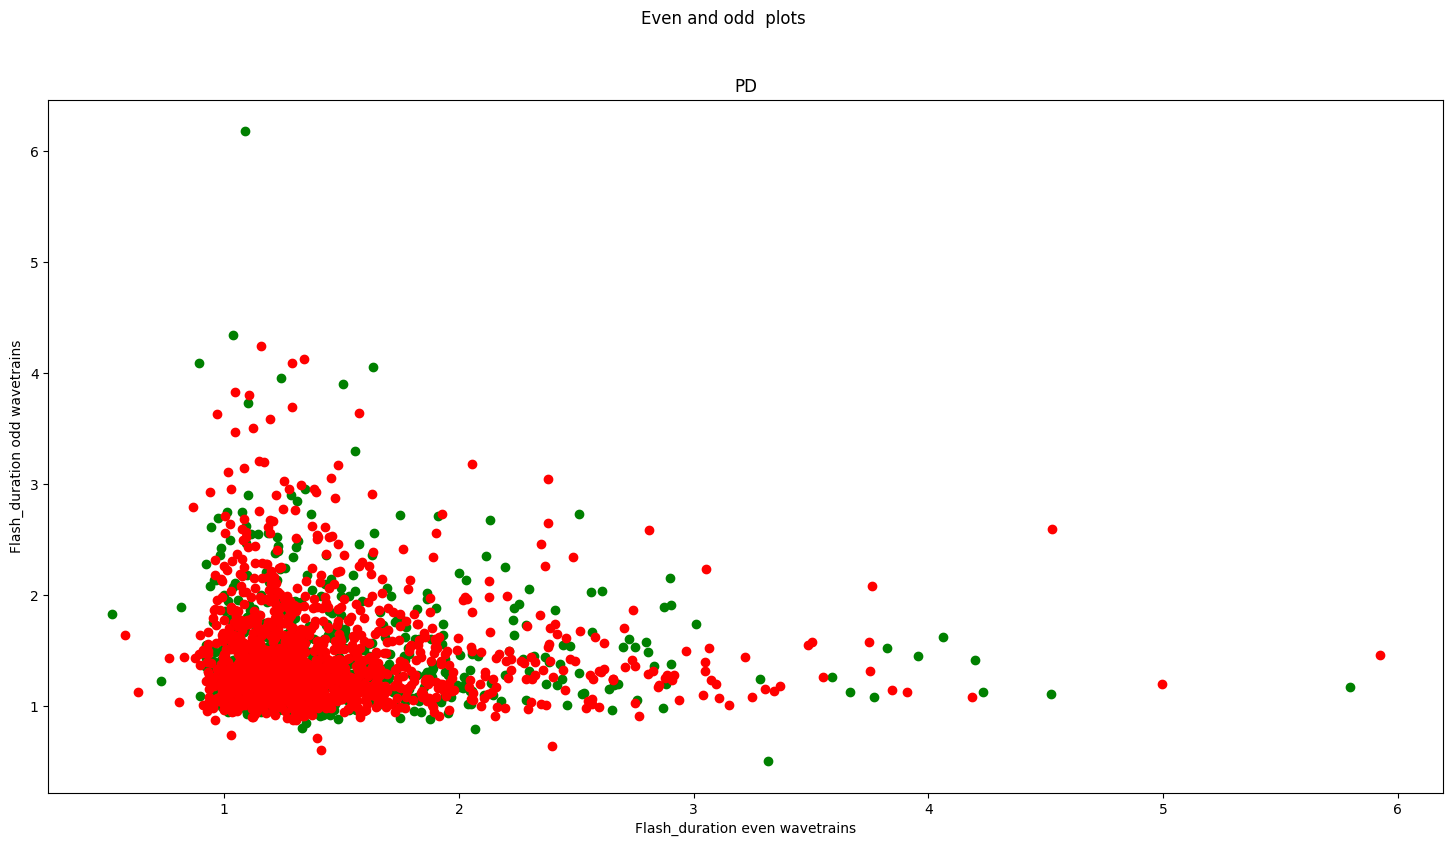

In [35]:
freq_valid = [0,6] # 0 
fig, axs = plt.subplots(figsize=(18,9))
for i in range(0,len(df),4): # take only flash_fr
    label = df.iloc[[i]][0].values[0]
    flash_d = df.iloc[[i+1]].values.tolist()[0]
    freq_range = df.iloc[[i]].values.tolist()[0]
    time_v = df.iloc[[i+3]].values.tolist()[0]
    valid_indexes = [i for i in range(2,len(freq_range)) if str(freq_range[i]) !='nan' and  freq_range[i]>freq_valid[0] and freq_range[i]<freq_valid[1]]
    flash_d = [flash_d[x] for x in valid_indexes]
    time_v = [time_v[x] for x in valid_indexes]
    if label == 'control':
        c = 'g' 
    elif label == 'PDR':
        c = 'r'
    else:
        continue
    even=flash_d[0::2]
    odd =flash_d[1::2]
    # only if the number of wavetrains is odd
    min_len = min(len(even),len(odd))
    even=even[:min_len]
    odd=odd[:min_len]
    axs.scatter(even, odd, color=c)
axs.set_xlabel('Flash_duration even wavetrains')
axs.set_ylabel('Flash_duration odd wavetrains')
axs.set_title(text)
fig.suptitle('Even and odd  plots')

In [ ]:
Построю теперь только БП правый и контроль, возьмем частоты от 30 до 40 Гц (почти все), построим frequency, получим красоту...

Text(0.5, 0.98, 'Even and odd  plots')

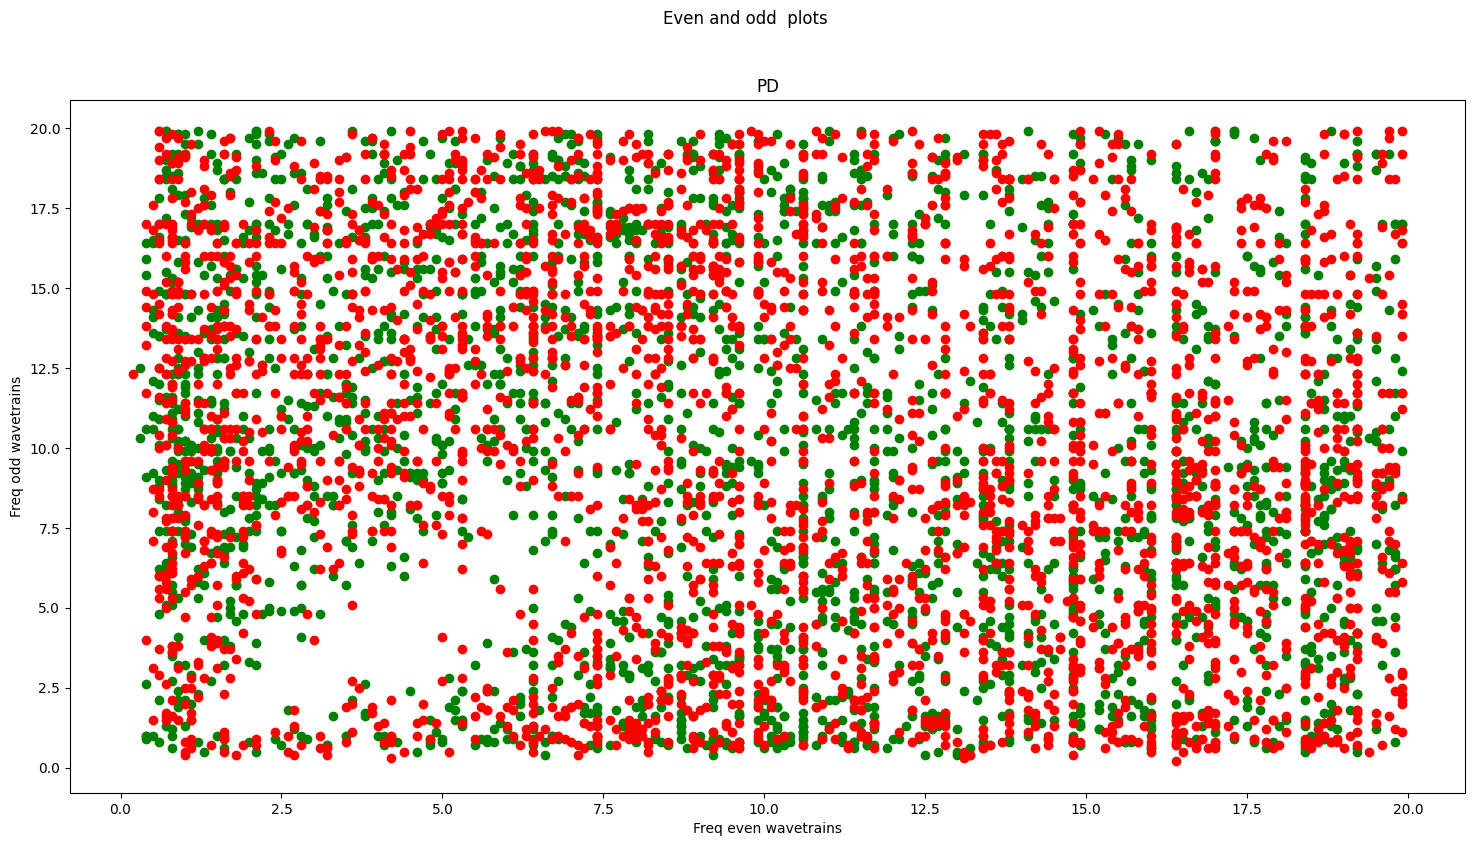

In [32]:
freq_valid = [0,20] # 0 
fig, axs = plt.subplots(figsize=(18,9))
for i in range(0,len(df),4): # take only flash_fr
    label = df.iloc[[i]][0].values[0]
    flash_d = df.iloc[[i+1]].values.tolist()[0]
    freq_range = df.iloc[[i]].values.tolist()[0]
    time_v = df.iloc[[i+3]].values.tolist()[0]
    valid_indexes = [i for i in range(2,len(freq_range)) if str(freq_range[i]) !='nan' and  freq_range[i]>freq_valid[0] and freq_range[i]<freq_valid[1]]
    flash_d = [flash_d[x] for x in valid_indexes]
    freq_range_d = [freq_range[x] for x in valid_indexes]
    time_v = [time_v[x] for x in valid_indexes]
    if label == 'control':
        c = 'g' 
    elif label == 'PDL' :#or label == 'PDR'
        c = 'r'
    else:
        continue
    even=freq_range_d[0::2]
    odd =freq_range_d[1::2]
    # only if the number of wavetrains is odd
    min_len = min(len(even),len(odd))
    even=even[:min_len]
    odd=odd[:min_len]
    axs.scatter(even, odd, color=c)
axs.set_xlabel('Freq even wavetrains')
axs.set_ylabel('Freq odd wavetrains')
axs.set_title(text)
fig.suptitle('Even and odd  plots')

Сейчас я обнаружил, что закономерности с duration in periods and in seconds есть не только у правотреморнвх, но и у левотреморных БП. Причем у левотреморных эффект даже сильнее. Из этого следует, что, если вручную отфильтровать всплески с центральной частотой меньше 6 Гц и сравнить длительность в периодах всплесков БП и контроля, отличия должны быть увидены. Во первых, на гистограммах, а во вторых, методами машинного обучения, включая нейросети. Эффекты очень сильные.
Если ничего не получится, то когда я приеду в Москву, сядем за компьютер и будем по шагами сравнивать все наши файлы, чтобы понять, откуда такой полтергейс

Text(0.5, 0.98, 'Even and odd  plots for PD Left and Control')

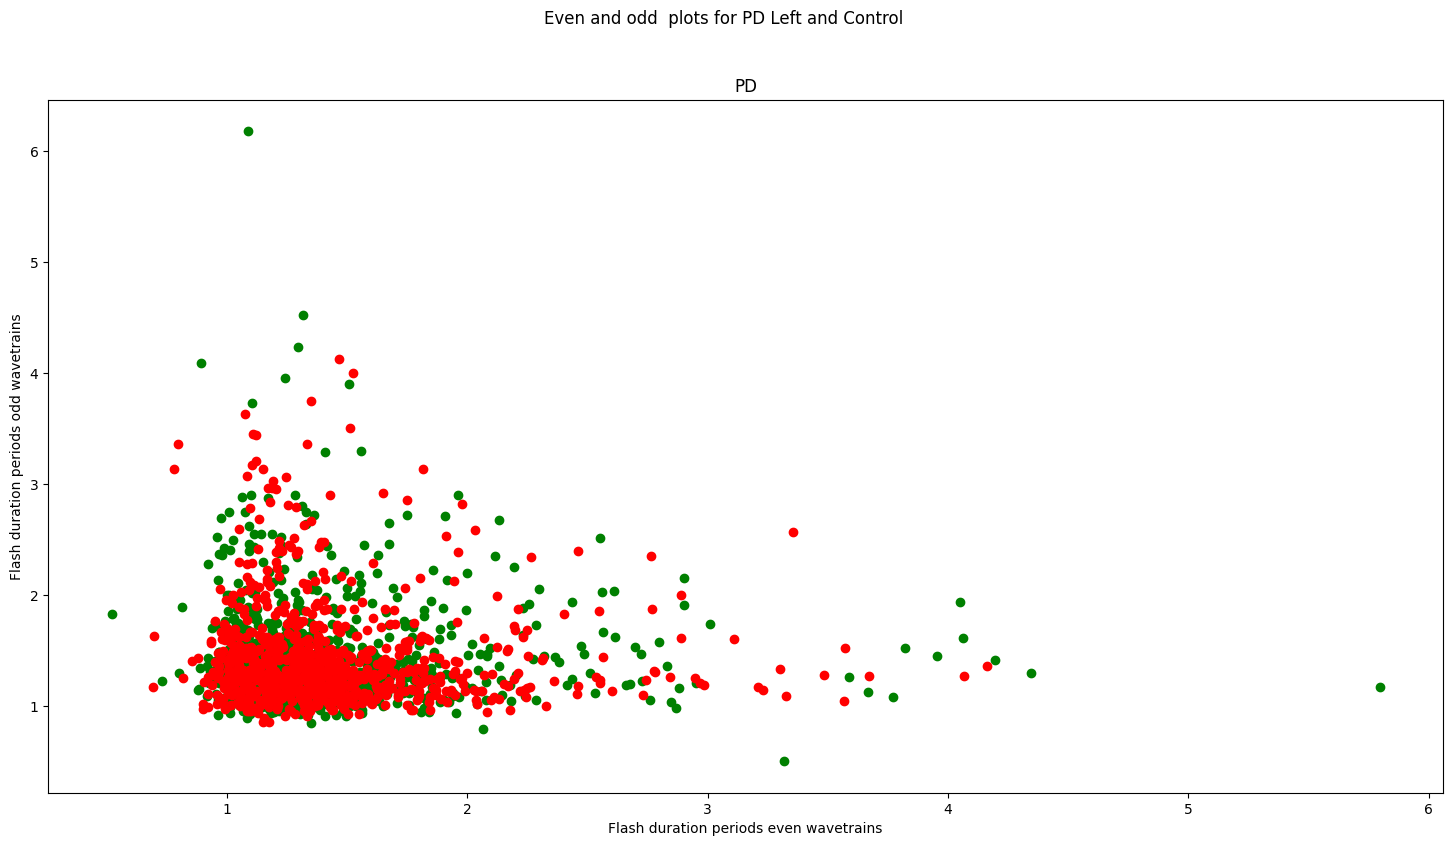

In [39]:
freq_valid = [0,6.1] # 0 
fig, axs = plt.subplots(figsize=(18,9))
for i in range(0,len(df),4): # take only flash_fr
    label = df.iloc[[i]][0].values[0]
    flash_d = df.iloc[[i+1]].values.tolist()[0]
    freq_range = df.iloc[[i]].values.tolist()[0]
    time_v = df.iloc[[i+3]].values.tolist()[0]
    valid_indexes = [i for i in range(2,len(freq_range)) if str(freq_range[i]) !='nan' and  freq_range[i]>freq_valid[0] and freq_range[i]<freq_valid[1]]
    flash_d = [flash_d[x] for x in valid_indexes]
    freq_range_d = [freq_range[x] for x in valid_indexes]
    time_v = [time_v[x] for x in valid_indexes]
    if label == 'control':
        c = 'g' 
    elif label == 'PDL' :#or label == 'PDR'
        c = 'r'
    else:
        continue
    even=flash_d[0::2]
    odd =flash_d[1::2]
    # only if the number of wavetrains is odd
    min_len = min(len(even),len(odd))
    even=even[:min_len]
    odd=odd[:min_len]
    axs.scatter(even, odd, color=c)
axs.set_xlabel('Flash duration periods even wavetrains')
axs.set_ylabel('Flash duration periods odd wavetrains')
axs.set_title(text)
fig.suptitle('Even and odd  plots for PD Left and Control')